In [61]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import _pickle as pickle

from pprint import pprint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("./files/paper.mplstyle")

from methods import *

np.random.seed(12345)

## Dynamics

In [2]:
state = {"n_f" : 492, "n_p" : 4, "n_m" : 4, "p_f" : 10, "p" : 10,}

params = {"sigma_eps" : 0.005, "sigma_mu" : 0.0, "t_c": 0.001, "gamma" : 0.01, 
          "beta": 4, "R": 0.0004, "s": 0.75, "alpha_1": 0.6, "alpha_2": 1.5, 
          "alpha_3": 1, "v_1": 2, "v_2": 0.6, "dt": 0.002}

In [3]:
M = LuxMarchesiModel(state, params)
print(M)

{'n_f': 492, 'n_p': 4, 'n_m': 4, 'p_f': 10, 'p': 10}


In [5]:
totalT = 10000
history = M.simulate(totalT, 1)

100%|██████████| 10000/10000 [01:54<00:00, 87.54it/s]


In [6]:
time = np.arange(0, totalT, 1)

In [7]:
def logReturns(prices, tau, norm=True):
    """
    Compute the log returns of a price time series.
    """
    ln_price = np.log(prices)
    diff = np.diff(ln_price, n=tau)
    if norm: diff = diff/np.std(diff)
    return diff

Text(0.5, 1.0, 'Zoomed in')

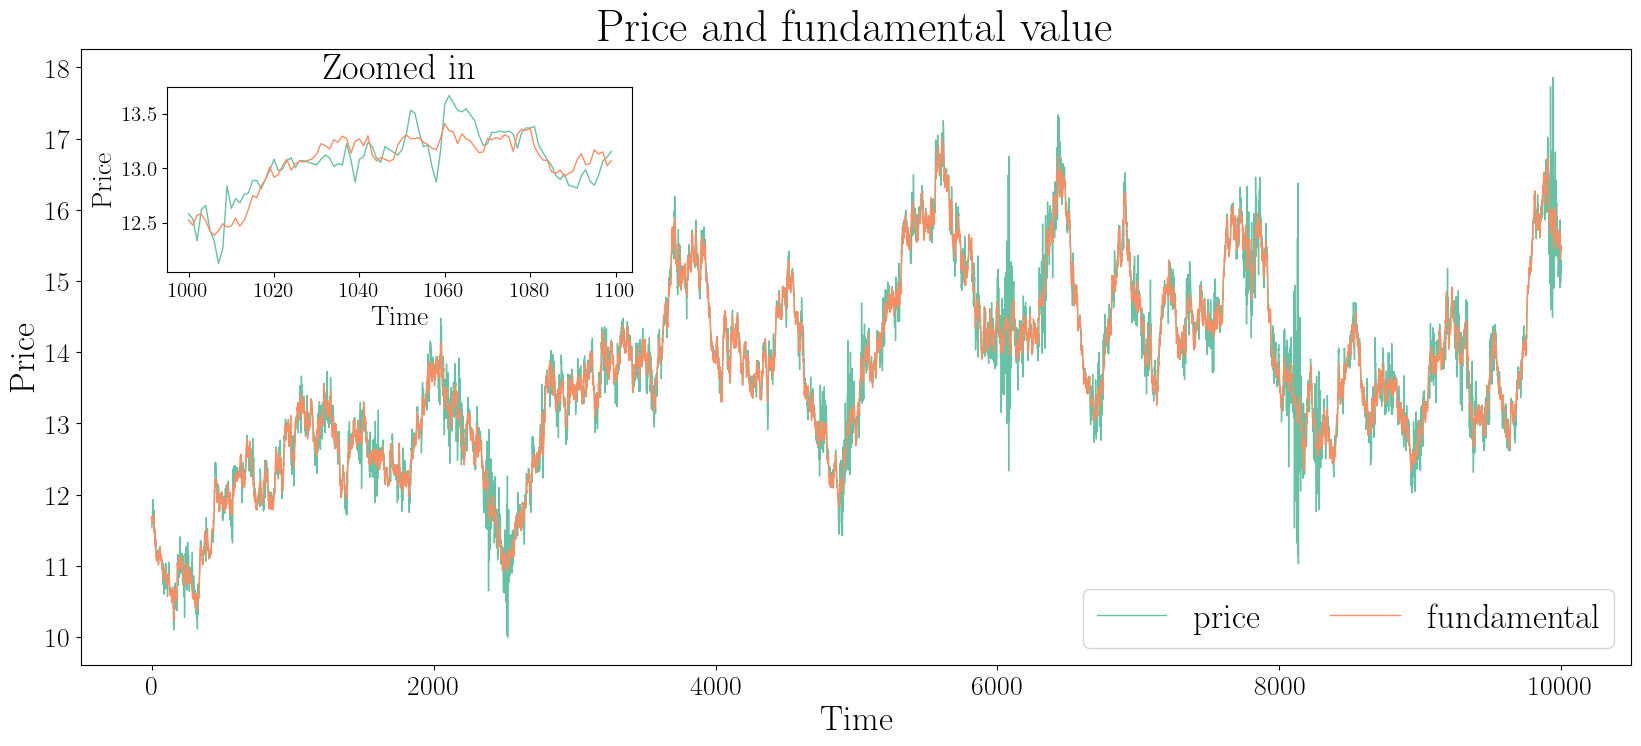

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
colors = sns.color_palette("Set2", 2)
cutoff = (1000, 1100)
fontsize = 25

# Plot the price and the fundamental value
ax.plot(time, history["prices"], lw=1, color=colors[0], label="price")
ax.plot(time, history["fundamentals"], lw=1, color=colors[1], label="fundamental")
ax.set_xlabel("Time", fontsize=fontsize)
ax.set_ylabel("Price", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax.set_title("Price and fundamental value", fontsize=fontsize*1.3)
ax.legend(loc="lower right", fontsize=fontsize, ncol=2)

# Inset with zoomed in plot
inset_ax = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.06, 0.65, 0.3, 0.3), bbox_transform=ax.transAxes)
inset_ax.plot(time[cutoff[0]:cutoff[1]], history["prices"][cutoff[0]:cutoff[1]], lw=1, color=colors[0], label="price")
inset_ax.plot(time[cutoff[0]:cutoff[1]], history["fundamentals"][cutoff[0]:cutoff[1]], lw=1, color=colors[1], label="fundamental")
inset_ax.set_xlabel("Time", fontsize=fontsize*0.8)
inset_ax.set_ylabel("Price", fontsize=fontsize*0.8)
inset_ax.tick_params(axis='both', which='major', labelsize=fontsize*0.6)
inset_ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.6)
inset_ax.set_title("Zoomed in", fontsize=fontsize*1.3*0.8)

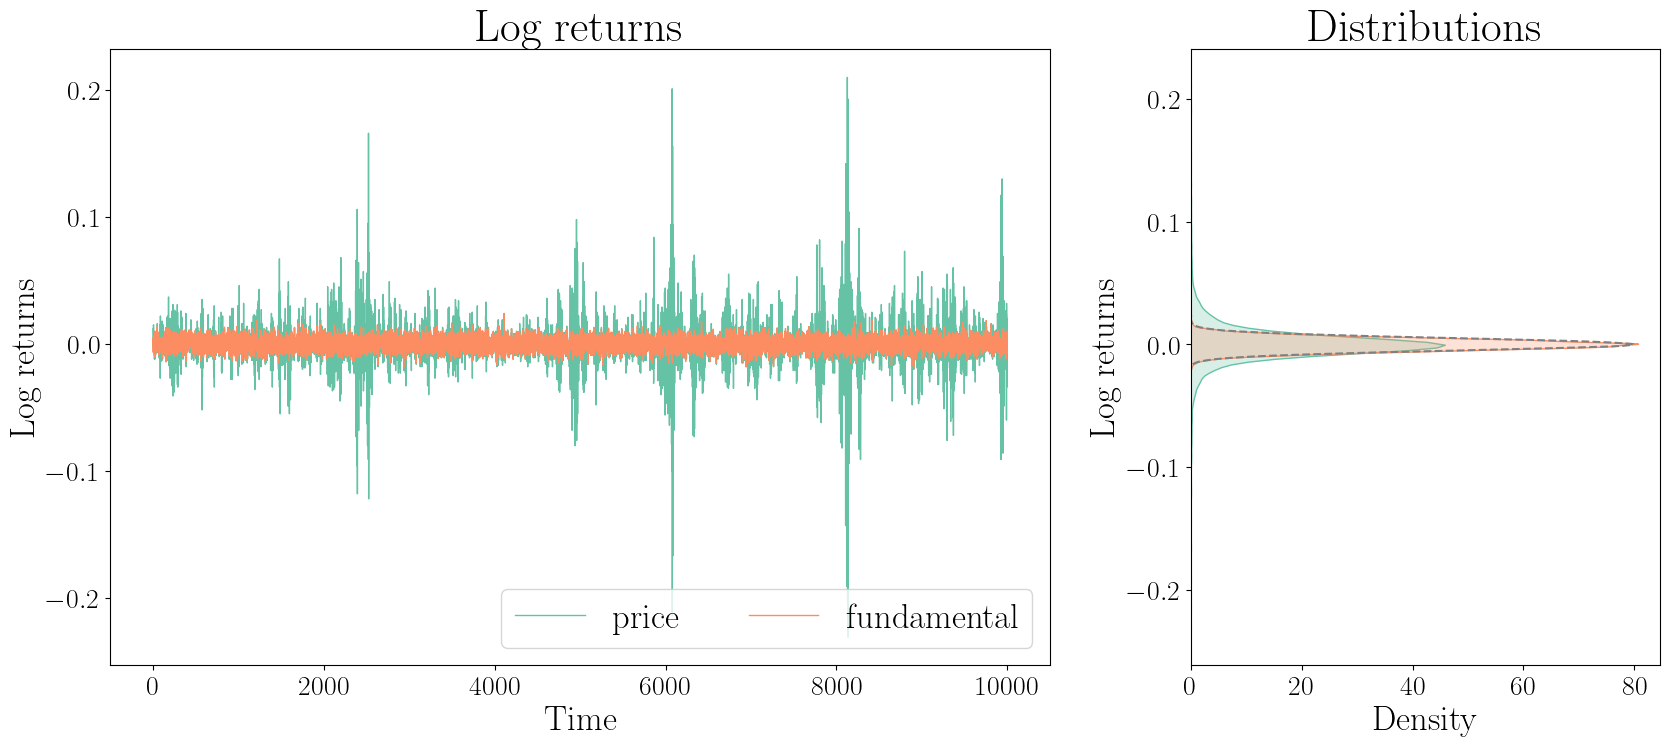

In [98]:
fig = plt.figure(figsize=(20, 8))
fontsize = 25

ret = np.diff(np.log(history["prices"]))
eps = np.diff(np.log(history["fundamentals"]))

# Define the gridspec to allocate more space to the first plot
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# First subplot (series)
ax1 = plt.subplot(gs[0])
ax1.plot(time[1:], ret, lw=1, color=colors[0], label="price")
ax1.plot(time[1:], eps, lw=1, color=colors[1], label="fundamental")
ax1.set_xlabel("Time", fontsize=fontsize)
ax1.set_ylabel("Log returns", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax1.set_title("Log returns", fontsize=fontsize*1.3)
ax1.legend(loc="lower right", fontsize=fontsize, ncol=2)

# Second subplot (distributions)
ax2 = plt.subplot(gs[1])
sns.kdeplot(y=ret, color=colors[0], ax=ax2, label="price", fill=True)
sns.kdeplot(y=eps, color=colors[1], ax=ax2, label="fundamental", fill=True)
sns.kdeplot(y=np.random.normal(0, params["sigma_eps"], int(1e6)), color="grey", ax=ax2, label="normal", linestyle="--")
ax2.set_xlabel("Density", fontsize=fontsize)
ax2.set_ylabel("Log returns", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax2.set_title("Distributions", fontsize=fontsize*1.3)

plt.show()


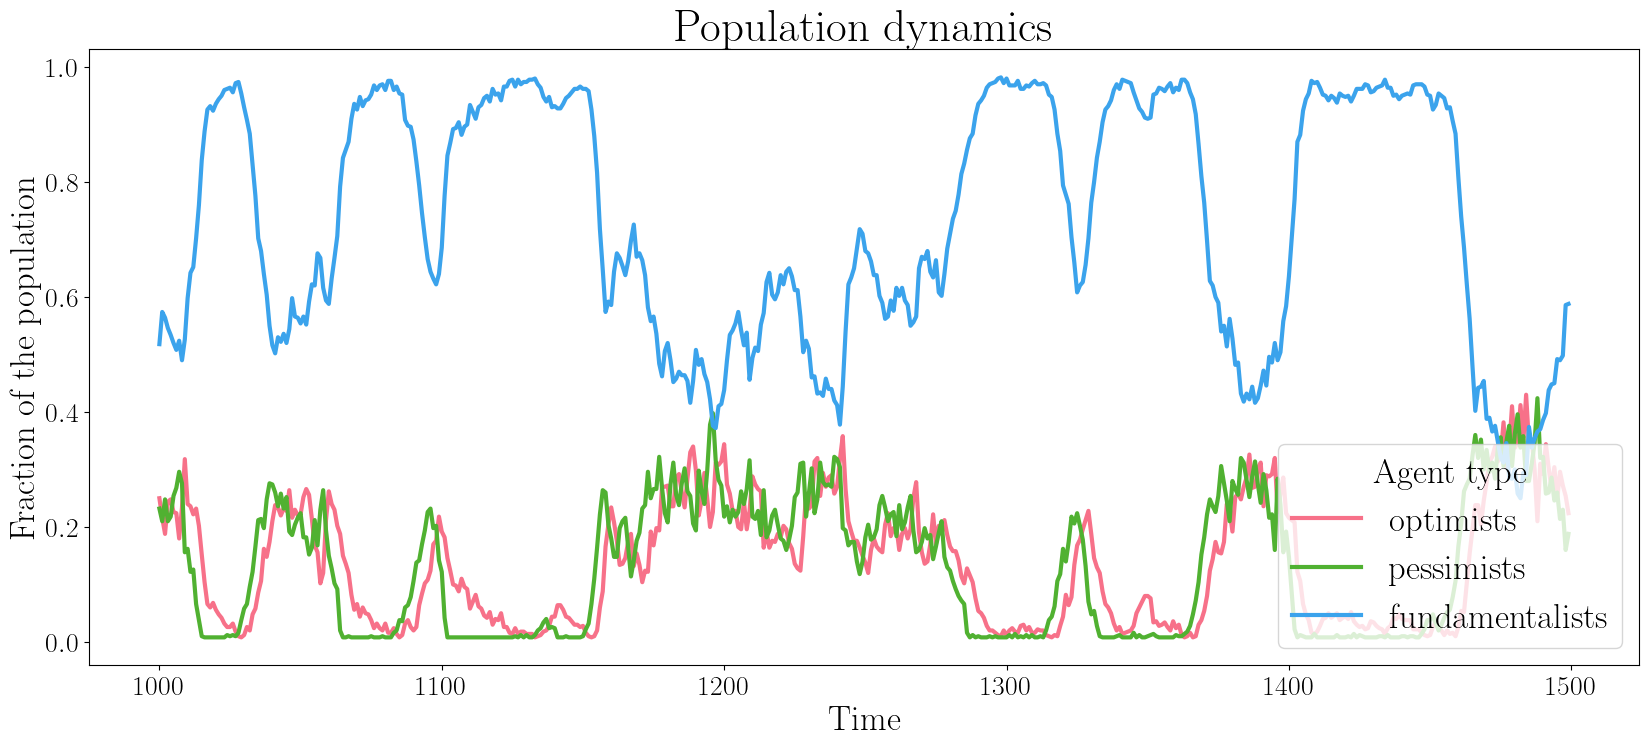

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
fontsize = 25
N = state["n_p"] + state["n_m"] + state["n_f"]
cutoff = (1000, 1500)
colors_pop = sns.color_palette("husl", 3)

ax.plot(time[cutoff[0]:cutoff[1]], history["optimists"][cutoff[0]:cutoff[1]]/N, lw=3, color=colors_pop[0], label="optimists")
ax.plot(time[cutoff[0]:cutoff[1]], history["pessimists"][cutoff[0]:cutoff[1]]/N, lw=3, color=colors_pop[1], label="pessimists")
ax.plot(time[cutoff[0]:cutoff[1]], history["fundamentalists"][cutoff[0]:cutoff[1]]/N, lw=3, color=colors_pop[2], label="fundamentalists")

ax.set_xlabel("Time", fontsize=fontsize)
ax.set_ylabel("Fraction of the population", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax.set_title("Population dynamics", fontsize=fontsize*1.3)
legend = ax.legend(loc="lower right", fontsize=fontsize, ncol=1)
legend.set_title("Agent type", prop={"size": fontsize})
legend.set_alpha(1)

## Long dynamics

In [115]:
# Load the data
with open("files/simul.pkl", "rb") as f:
    history = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'files/simul.pkl'

In [94]:
def empiricalCDF(data):
    """
    Compute the empirical CDF of a dataset.
    """
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

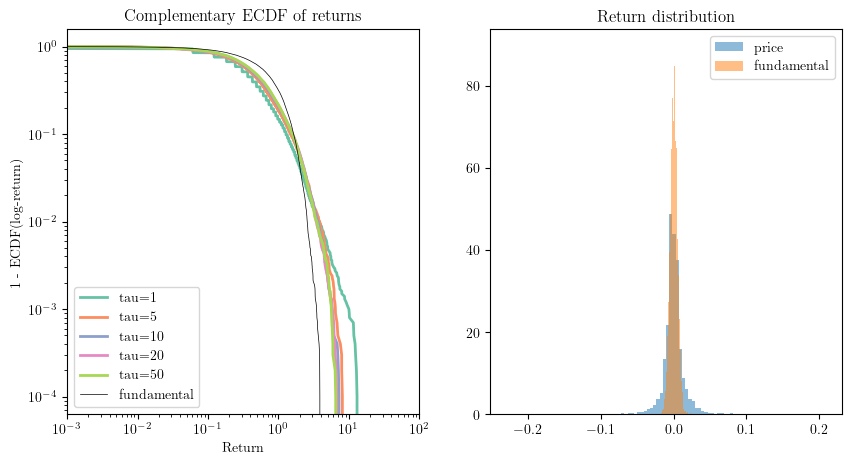

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prices = history["prices"]
fundamentals = history["fundamentals"]

tau_list = [1, 5, 10, 20, 50]
markers = ["o", "s", "D", "^", "v"]
colors = sns.color_palette("Set2", len(tau_list))
for tau, marker, color in zip(tau_list, markers, colors):
    # Compute the return for the given tau
    ret = np.abs(logReturns(prices, tau))
    
    # Compute the ECDF and plot the complement
    x, y = empiricalCDF(ret)
    ax[0].loglog(x, 1-y, label=f"tau={tau}", marker="", color=color, 
                 markersize=1, linestyle="-", linewidth=2)

x, y = empiricalCDF(np.abs(logReturns(fundamentals, 1)))
ax[0].loglog(x, 1-y, label="fundamental", marker="", color="black", 
             markersize=1, linestyle="-", linewidth=0.5)
ax[0].legend()
ax[0].set_title("Complementary ECDF of returns")
ax[0].set_xlabel("Return")
ax[0].set_ylabel("1 - ECDF(log-return)")
ax[0].set_xlim(1e-3, 100)

ax[1].set_title("Return distribution")
ax[1].hist(logReturns(prices, 1, False), bins=100, alpha=0.5, density=True, label="price")
ax[1].hist(logReturns(fundamentals, 1, False), bins=100, alpha=0.5, density=True, label="fundamental")
ax[1].legend();

In [109]:
def movingAverage(data, w):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    avg = (cumsum[w:] - cumsum[:-w]) / float(w)
    return avg

In [110]:
data = history["prices"]
k = 10 # Window size

def getFluctuation(data, k):
    """
    Compute the fluctuation strength of a time series.
    """
    #Split into M segments of length k
    num_segments = len(data) // k
    segments = np.array_split(data[:num_segments * k], num_segments)

    #Local fit for each segment
    def fit_polynomial(segment, order=1):
        x = np.arange(len(segment))
        coeffs = np.polyfit(x, segment, order)
        fitted_values = np.polyval(coeffs, x)
        return fitted_values

    def fit_polynomials_to_segments(segments, order=1):
        fitted_segments = [fit_polynomial(segment, order) for segment in segments]
        return fitted_segments

    # Linear fit of the segments
    fitted_segments = fit_polynomials_to_segments(segments, 1)

    # Compute the fluctuation strength for each segment
    f_strengths = np.zeros(len(segments))
    for q in range(len(segments)):
        # Compute root mean square of the fluctuations
        squared_fluctuations = (segments[q] - fitted_segments[q])**2
        fluctuation = np.mean(squared_fluctuations)**0.5
        f_strengths[q] = fluctuation

    return np.mean(f_strengths)


def doDFA(data, max_data=None, num_points=30):
    """
    Perform Detrended Fluctuation Analysis on a time series.
    """
    if max_data is None: max_data = len(data)
    lengths = np.logspace(2, np.log(max_data), base=np.e, num=num_points, dtype=int)
    fluctuations = [getFluctuation(data, k) for k in lengths]

    return lengths, fluctuations
    

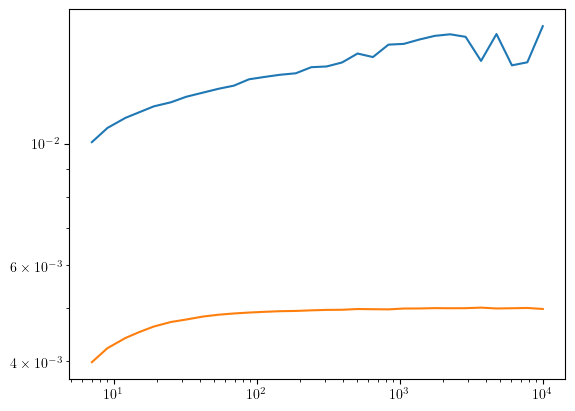

In [114]:
ret = logReturns(history["prices"], 1, False)
lengths, fluctuations = doDFA(ret)
eps = logReturns(history["fundamentals"], 1, False)
lengths_f, fluctuations_f = doDFA(eps)
plt.plot(lengths, fluctuations, label="price")
plt.plot(lengths_f, fluctuations_f, label="fundamental")

plt.xscale("log")
plt.yscale("log")